# Compare Prophet forecasting results to current PRA forecasting

Let's define some plotting functions

In [17]:
PlotTheData = function(dFResults,str_pod, metric_label,TTL,ylimMin,ylimMax,timestamps_breakpoints) {
    plot1 = ggplot(dFResults, aes(x = timestamp, y = data), ann=FALSE)+ ggtitle(str_pod)+theme(axis.title.x=element_blank())
    plot1 = plot1 + geom_point(na.rm=TRUE) + geom_line(na.rm=TRUE) + ylab(metric_label)
    plot1 = plot1 + geom_line(aes(x = timestamp, y = dataForecast),colour= "blue",na.rm=TRUE)
    plot1 = plot1 + geom_ribbon(aes(ymin=dataForecastConfidenceLB, ymax=dataForecastConfidenceUB),alpha=0.3)

    plot1 = plot1 + geom_hline(aes(yintercept=TTL),colour="black",linetype=2)
    plot1 = plot1 + scale_x_datetime(limit=c(min(dFResults$timestamp),max(dFResults$timestamp)),date_breaks = "3 month", date_minor_breaks = "1 month", date_labels = "%Y-%m-%d")
    #plot1 = plot1 + scale_y_continuous(limit=c(minLim,maxLim), breaks = major_breaks, minor_breaks = minor_breaks )
    plot1 = plot1 + scale_y_continuous(limit=c(ylimMin,ylimMax))
    
    #if(exists("timestamps_breakpoints")) {
    #if(!missing(TTL))
    #    if (length(timestamps_breakpoints) > 0) {
    #        plot1 = plot1 + geom_vline(xintercept=as.numeric(timestamps_breakpoints),colour= "yellow")#quantile_resultsDF[slope_breakpoints,"timestamp"]
    #    }
    #}
    griddMt =grid.arrange(plot1)
}
PlotJustTimeSeries = function (dataDF,str_pod,metric_label,TTL,ylimMin,ylimMax) {
    plot1 = ggplot(dataDF, aes(x = timestamp, y = data), ann=FALSE)+ ggtitle(str_pod)+theme(axis.title.x=element_blank())
    plot1 = plot1 + geom_point(na.rm=TRUE) + geom_line(na.rm=TRUE) + ylab(metric_label)
    plot1 = plot1 + geom_hline(aes(yintercept=TTL),colour="black",linetype=2)
    plot1 = plot1 + scale_x_datetime(limit=c(min(dataDF$timestamp),max(dataDF$timestamp)),date_breaks = "3 month", date_minor_breaks = "1 month", date_labels = "%Y-%m-%d")
    plot1 = plot1 + scale_y_continuous(limit=c(ylimMin,ylimMax))
    
    griddMt =grid.arrange(plot1)
}

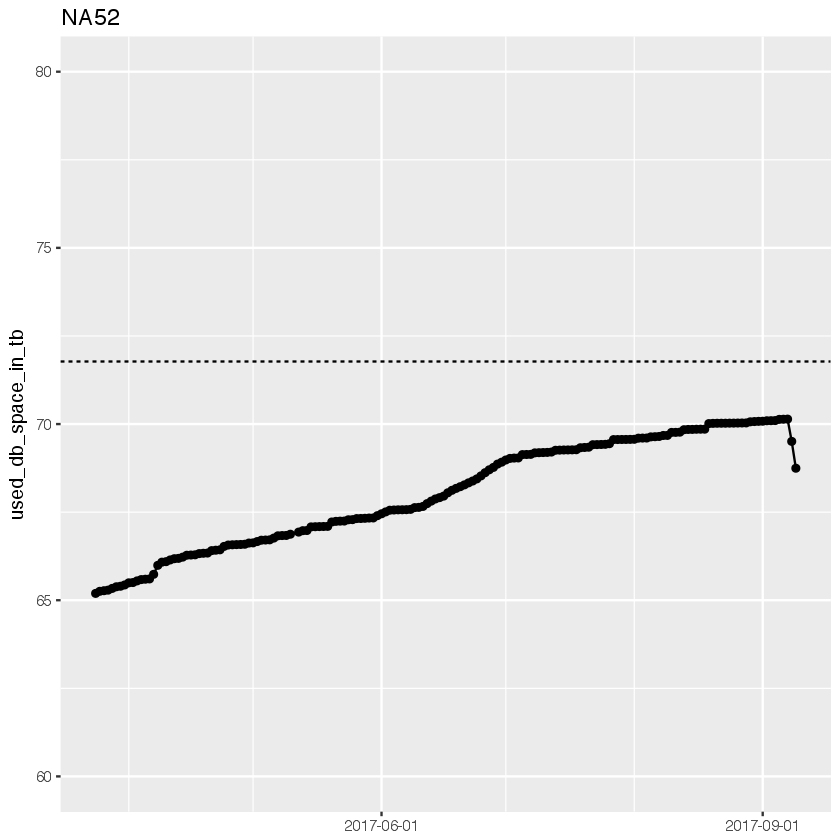

In [18]:
source_file_dir='/Users/abertran/Documents/gitRepositories/TTL_prod_code/'

source(paste(source_file_dir,"source_common_files.R",sep=""))

source(paste(source_file_dir,"readDBSizeDatadB.R",sep=""))
source(paste(source_file_dir,"parameters_DBSize.R",sep=""))

data = readDBSizeDatadB()
data$pod = toupper(data$pod)
str_pod="NA52"
metric_name= "used_db_space_in_tb"
pod_data=data[which(data$pod==str_pod),]
start_date=as.POSIXct('2017-03-23', format="%Y-%m-%d",tz="UTC",origin="1970-01-01")

arraySize = 89
TTL = (arraySize - 15) * 0.97


pod_data=pod_data[which(pod_data$timestamp>start_date),]
pod_dataDF=as.data.frame(pod_data$timestamp)
pod_dataDF$data=pod_data$used_db_space_in_tb
colnames(pod_dataDF)=c("timestamp","data")
PlotJustTimeSeries(dataDF=pod_dataDF,str_pod=str_pod,metric_label=metric_name,TTL=TTL,60,80)

Warning message in set_auto_seasonalities(m):
“Disabling yearly seasonality. Run prophet with `yearly.seasonality=TRUE` to override this.”trying deprecated constructor; please alert package maintainer


Initial log joint probability = -2.0426
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


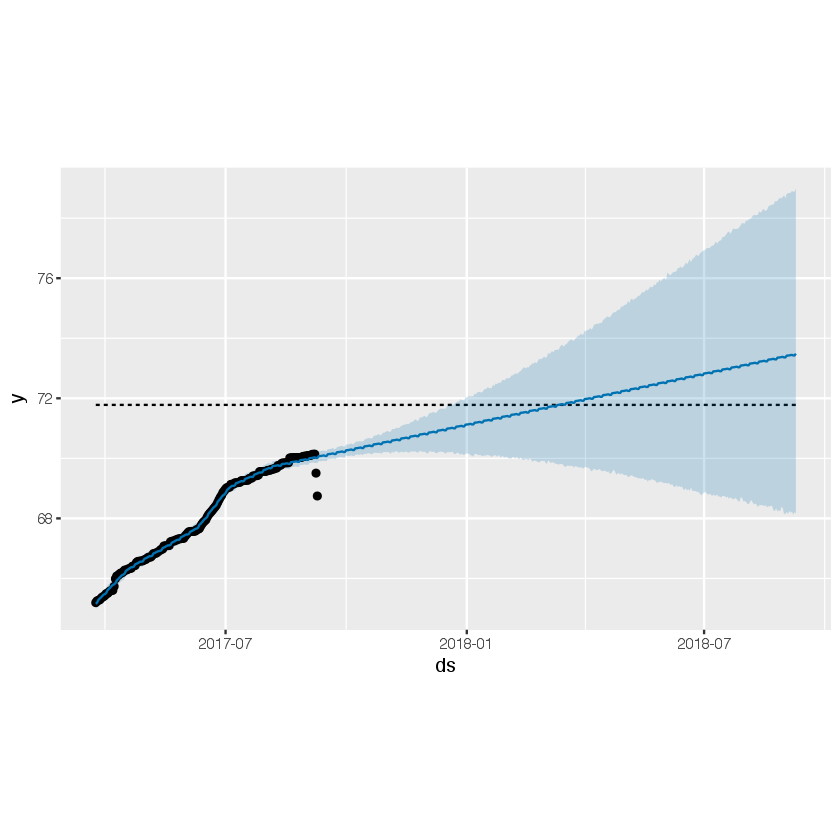

In [35]:
library(prophet)

df = as.data.frame(pod_data$timestamp)
df$y=pod_data$used_db_space_in_tb
colnames(df)=c('ds','y')
library(dplyr)
m <- prophet(df, changepoint.prior.scale = 0.01, n.changepoints=100)
future <- make_future_dataframe(m, periods = 365)
forecast <- predict(m, future)
arraySize = 89
forecast['cap'] = (arraySize - 15) * 0.97
plot(m, forecast,ylim=c(60,80))

[1] 71.78


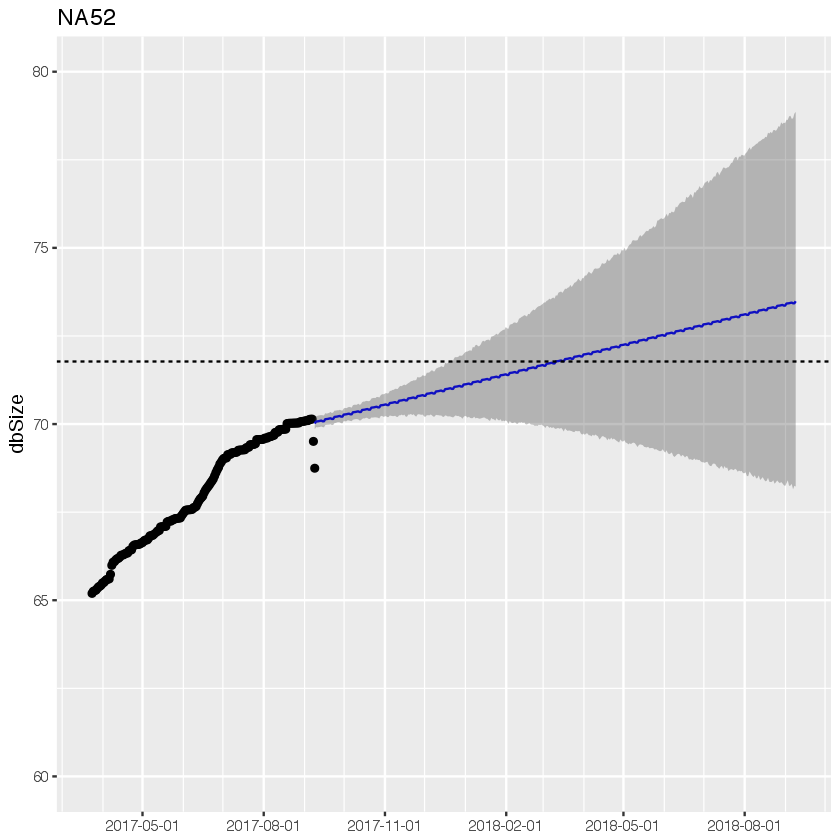

In [20]:
n_timeseries=dim(df)[1]
n_prediction=dim(future)[1]
n_data=n_timeseries+n_prediction
dFResults=as.data.frame(1:n_data)
future_timestamps=as.POSIXct(as.character(forecast$ds), format="%Y-%m-%d",tz="UTC",origin="1970-01-01")
dFResults$timestamp=c(df$ds,future_timestamps)
dFResults$data=c(df$y,rep(NA,n_prediction))
#dFResults$dataModel=
dFResults$dataForecast=c(rep(NA,n_timeseries),forecast$yhat)
dFResults$dataForecastConfidenceUB=c(rep(NA,n_timeseries),forecast$yhat_upper)
dFResults$dataForecastConfidenceLB=c(rep(NA,n_timeseries),forecast$yhat_lower)

#timestamps_breakpoints=m$changepoints
TTL=(arraySize - 15) * 0.97
metric_label="dbSize"
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=60,ylimMax=80)

print(TTL)

Comparing to current PRA forecast
The forecast above gives a TTL of between ~1.9 and 3 months [each x-axis break is 1 month]. PRA is calling out 5 months. However, note that we can't compare above result as is to the current PRA forecast because the current PRA forecast does not use the same threshold; instead of using TTL=(arraySize - 15) * 0.97=71.78 Tb it uses TTL according to total ASM allocated which currently is 75.65 Tb. Let's run the above analysis with the same TTL as PRA.

[1] 75.64758


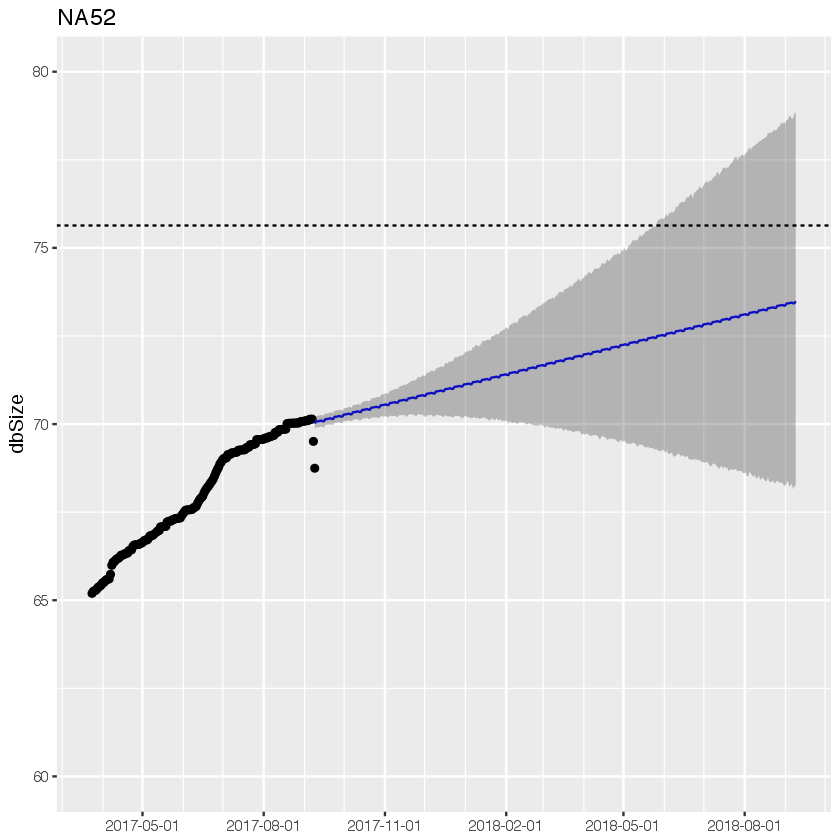

In [21]:
TTL=pod_data[dim(pod_data)[1],"total_db_size_in_tb"]
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=60,ylimMax=80)

print(TTL)

Now prophet is calling between 5 and 9.9 months. Remember that PRA's conservative estimate was 5 months as of 9/1/2017

Note that above we have used a large number of change points 100 as prophet puts change points at regular intervals. By default prophet uses 25 change points regularly spaced. Choosing a large number of changepoints ensures we don't miss an actual change point. 
Let's change the changepoint parameters some more to see what Prophet's results are. Here we change the changepoint.prior.scale
Changepoint.prior.scale: is a parameter modulating the flexibility of the automatic changepoint selection. Large values will allow many changepoints, small values will allow few changepoints. The default value is 0.05 if none is specified. The value ranges from 0, no flexibility that is no change points taken into account to ...

Warning message in set_auto_seasonalities(m):
“Disabling yearly seasonality. Run prophet with `yearly.seasonality=TRUE` to override this.”trying deprecated constructor; please alert package maintainer


Initial log joint probability = -2.0426
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


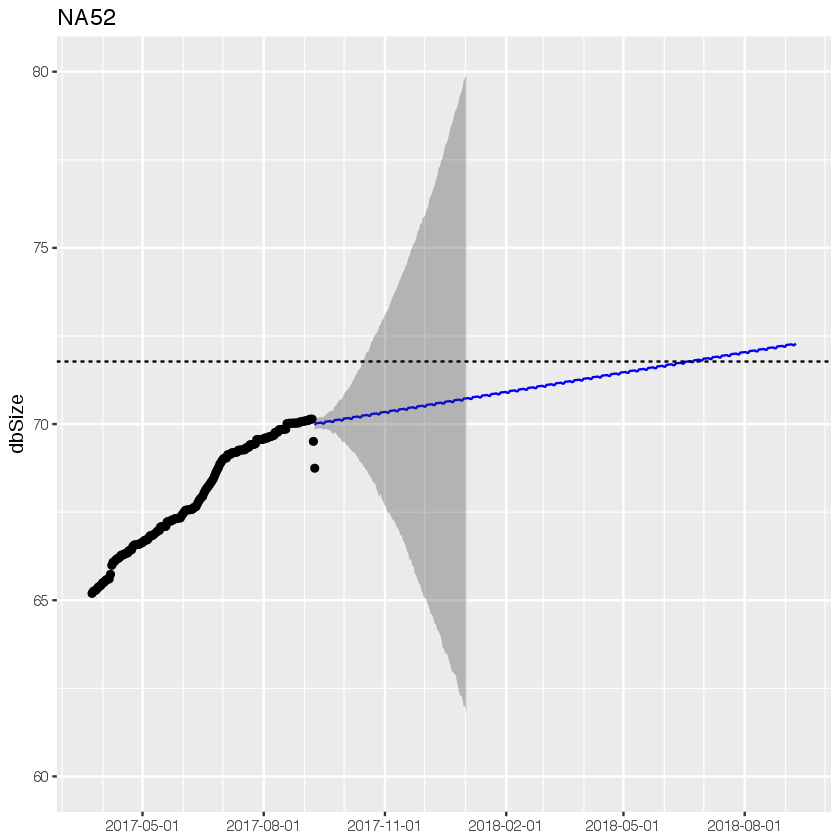

In [31]:
m2 <- prophet(df, changepoint.prior.scale = 0.9)
future <- make_future_dataframe(m2, periods = 365)
forecast <- predict(m2, future)
TTL=(arraySize - 15) * 0.97
dFResults=as.data.frame(1:n_data)
future_timestamps=as.POSIXct(as.character(forecast$ds), format="%Y-%m-%d",tz="UTC",origin="1970-01-01")
dFResults$timestamp=c(df$ds,future_timestamps)
dFResults$data=c(df$y,rep(NA,n_prediction))
#dFResults$dataModel=
dFResults$dataForecast=c(rep(NA,n_timeseries),forecast$yhat)
dFResults$dataForecastConfidenceUB=c(rep(NA,n_timeseries),forecast$yhat_upper)
dFResults$dataForecastConfidenceLB=c(rep(NA,n_timeseries),forecast$yhat_lower)
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=60,ylimMax=80)

Changing the changepoint.prior.scale to 0.9 has resulted in wider intervals. Now the pessimistic TTL is ~1 month.

Try giving Prophet the change points detected using PRA's algorithm for change point detection

[1] "2017-04-06" "2017-04-08" "2017-06-11" "2017-07-02"

Warning message in set_auto_seasonalities(m):
“Disabling yearly seasonality. Run prophet with `yearly.seasonality=TRUE` to override this.”trying deprecated constructor; please alert package maintainer


Initial log joint probability = -2.0426
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


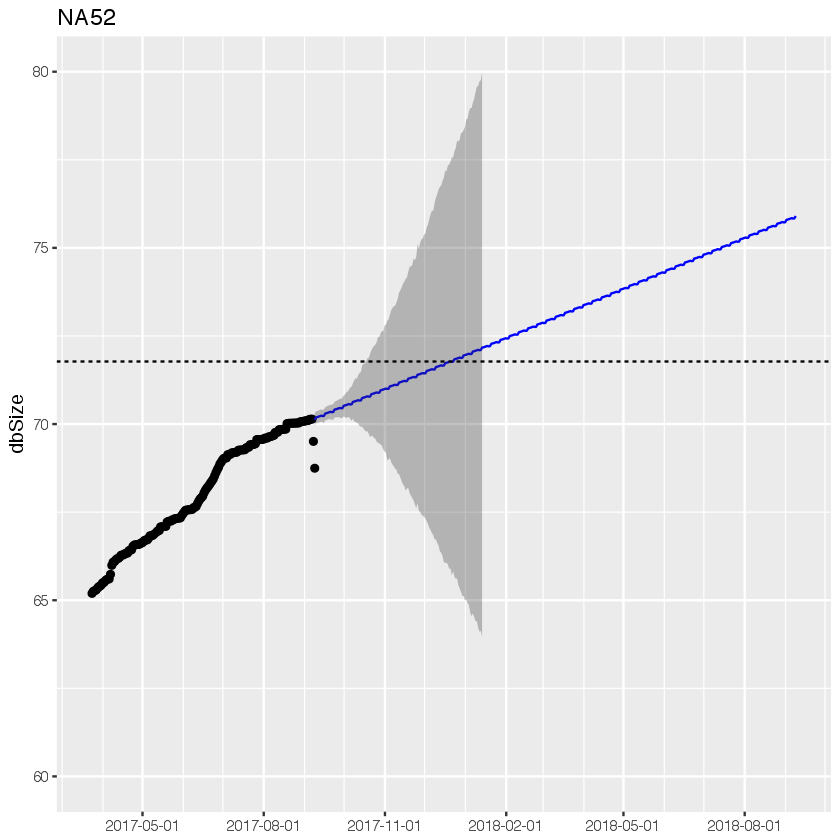

In [32]:
changepoints_from_pra=c("2017-04-06","2017-04-08","2017-06-11","2017-07-02")
#changepoints_from_pra=as.POSIXct(changepoints_from_pra, format="%Y-%m-%d",tz="UTC",origin="1970-01-01")
changepoints_from_pra=as.Date(changepoints_from_pra,format="%Y-%m-%d")
changepoints_from_pra
#c(min(df$ds),max(df$ds))
#max(changepoints_from_pra)>max(df$ds)
#start_date=as.POSIXct('2017-03-23', format="%Y-%m-%d",tz="UTC",origin="1970-01-01")
m <- prophet(df, changepoints=changepoints_from_pra)#, changepoint.prior.scale = 0.01
future <- make_future_dataframe(m, periods = 365)
forecast <- predict(m, future)
arraySize = 89
forecast['cap'] = (arraySize - 15) * 0.97
dFResults=as.data.frame(1:n_data)
future_timestamps=as.POSIXct(as.character(forecast$ds), format="%Y-%m-%d",tz="UTC",origin="1970-01-01")
dFResults$timestamp=c(df$ds,future_timestamps)
dFResults$data=c(df$y,rep(NA,n_prediction))
#dFResults$dataModel=
dFResults$dataForecast=c(rep(NA,n_timeseries),forecast$yhat)
dFResults$dataForecastConfidenceUB=c(rep(NA,n_timeseries),forecast$yhat_upper)
dFResults$dataForecastConfidenceLB=c(rep(NA,n_timeseries),forecast$yhat_lower)
PlotTheData(dFResults=dFResults, str_pod=str_pod, metric_label=metric_label, TTL=TTL,ylimMin=60,ylimMax=80)